# 📑 Overview of the Notebook

This notebook presents a complete workflow for **exploring, cleaning, and transforming medical case data stored in XML files**.  
The objective is to convert raw, unstructured information into structured datasets that can be analyzed and integrated into an **OLAP model** for deeper insights.

---

## 🔹 Key Steps in the Workflow

- **Raw Data Understanding**
  - Mount Google Drive and load XML files.
  - Parse the XML structure to identify unique tags and relationships.

- **Division into Four Main DataFrames**
  - `df_main`: Core case metadata (ID, Diagnosis, Description, Age, Hospital, etc.).
  - `df_qcm`: Multiple-choice questions linked to cases.
  - `df_weblink`: External references (limited observations).
  - `df_link`: Internal links between cases (limited observations).

- **Data Cleaning & Preparation**
  - Handle missing values and drop sparse columns using a threshold.
  - Correct column data types (dates, numbers, categorical fields).
  - Combine `Date` and `DateTime` into a unified `Timestamp`.
  - Standardize categorical values (e.g., Department names).
  - Recover missing demographic data:
    - Extract **Age** and **Sex** from `ClinicalPresentation` text.

- **Textual Feature Extraction**
  - Mine unstructured text (`Description`, `Diagnosis`, `ClinicalPresentation`) to derive structured features.
  - Extract **case severity** using keyword-based scoring.
  - Normalize and group **diagnoses** (root terms).
  - Identify **affected organs** using biomedical NER models (GLiNER).

- **Analytical Vision**
  - Prepare the dataset for OLAP cubes and dashboards.
  - Enable demographic, diagnostic, and severity-based analysis of patient cases.

---

## 🎯 Purpose

This notebook transforms raw XML medical case files into **clean, structured, and enriched datasets**.  
By combining data cleaning, NLP, and feature extraction, it provides a foundation for **decision support systems, analytical dashboards, and advanced medical insights**.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**Importer Data**

In [ ]:
import glob
import os


In [ ]:
import os

folder_path = '/content/drive/MyDrive/casimage_FR'
os.listdir(folder_path)


['case2827_fr.xml',
 'case2792_fr.xml',
 'case2834_fr.xml',
 'case2873_fr.xml',
 'case2843_fr.xml',
 'case2806_fr.xml',
 'case2865_fr.xml',
 'case2842_fr.xml',
 'case2836_fr.xml',
 'case2851_fr.xml',
 'case2874_fr.xml',
 'case2868_fr.xml',
 'case2781_fr.xml',
 'case2838_fr.xml',
 'case2975_fr.xml',
 'case2824_fr.xml',
 'case2963_fr.xml',
 'case2885_fr.xml',
 'case2872_fr.xml',
 'case2801_fr.xml',
 'case2820_fr.xml',
 'case2977_fr.xml',
 'case2982_fr.xml',
 'case3088_fr.xml',
 'case3004_fr.xml',
 'case3010_fr.xml',
 'case3134_fr.xml',
 'case3037_fr.xml',
 'case3126_fr.xml',
 'case3129_fr.xml',
 'case3086_fr.xml',
 'case3114_fr.xml',
 'case3031_fr.xml',
 'case3077_fr.xml',
 'case3131_fr.xml',
 'case3125_fr.xml',
 'case3060_fr.xml',
 'case3017_fr.xml',
 'case3040_fr.xml',
 'case3085_fr.xml',
 'case3117_fr.xml',
 'case3110_fr.xml',
 'case3090_fr.xml',
 'case3118_fr.xml',
 'case3064_fr.xml',
 'case3127_fr.xml',
 'case3044_fr.xml',
 'case3058_fr.xml',
 'case3122_fr.xml',
 'case3042_fr.xml',


# Raw Data Understanding

In [ ]:
nb_fichiers = len(glob.glob(os.path.join(folder_path, "**/*.xml"), recursive=True))
print(f"Nombre total de fichiers XML : {nb_fichiers}")

Nombre total de fichiers XML : 1691


Parsing an XML Structure

In [ ]:
from lxml import etree
import os

# 🌳 Dictionnaire pour stocker les relations parent → enfants
structure = {}
# Ensemble pour stocker les balises uniques
unique_tags = set()

def add_to_structure(node, struct_dict):
    """Ajoute les balises à la structure globale et collecte les tags uniques"""
    unique_tags.add(node.tag)  # ajoute à l’ensemble des balises uniques

    if node.tag not in struct_dict:
        struct_dict[node.tag] = {}

    for child in node:
        add_to_structure(child, struct_dict[node.tag])

# 🔁 Parcourt tous les fichiers XML du dossier
parser = etree.XMLParser(recover=True)
for filename in os.listdir(folder_path):
    if filename.endswith(".xml"):
        file_path = os.path.join(folder_path, filename)
        try:
            tree = etree.parse(file_path, parser)
            root = tree.getroot()
            add_to_structure(root, structure)
        except Exception as e:
            print(f"⚠️ Erreur avec {filename}: {e}")

# 🖨️ Fonction d’affichage hiérarchique
def print_structure(struct_dict, level=0):
    for tag, children in struct_dict.items():
        print("  " * level + tag)
        print_structure(children, level + 1)

print("\n=== Structure générale de tous les fichiers XML ===")
print_structure(structure)

# 🧮 Affichage du nombre total de balises uniques
print(f"\n✅ Nombre total de balises uniques (tous fichiers confondus) : {len(unique_tags)}")



=== Structure générale de tous les fichiers XML ===
CASIMAGE_CASE
  ID
  Description
  Diagnosis
  Sex
  CaseID
  ClinicalPresentation
  Commentary
  KeyWords
  Anatomy
  Chapter
  ACR
  References
  Author
  Reviewer
  Hospital
  Department
  State
  Date
  Language
  Title
  Birthdate
  Age
  ImageThumbnaillID
  Creation
  DateTime
  Order
  OJoint
  OLocation
  OImplant
  ODislocation
  OPolytrauma
  OOpen
  OPathologic
  OOperation
  OGraft
  WEBURL
  QCM
    QUESTION
    ANSWERA
    ANSWERB
    ANSWERC
    ANSWERD
    COMMENTARY
  WEBLINK
    URL
    DESCRIPTION
  LINK
    ID
    COMMENTARY

✅ Nombre total de balises uniques (tous fichiers confondus) : 48


#Division into Four Main DataFrames

Every part of the XML structure that contains child elements was extracted into its own dedicated dataframe.

In [ ]:
from lxml import etree
import pandas as pd
import os
import glob

parser = etree.XMLParser(recover=True)

case_data = []
qcm_data = []
weblink_data = []
link_data = []

# 🔁 Parcours de tous les fichiers XML
for file in glob.glob(os.path.join(folder_path, "*.xml")):
    try:
        tree = etree.parse(file, parser)
        root = tree.getroot()

        # 🔹 Extraire les données principales
        case_info = {
            "NomFichier": os.path.basename(file),
            "ID": root.findtext(".//ID", default=None),
            "Description": root.findtext(".//Description", default=None),
            "Diagnosis": root.findtext(".//Diagnosis", default=None),
            "Sex": root.findtext(".//Sex", default=None),
            "CaseID": root.findtext(".//CaseID", default=None),
            "ClinicalPresentation": root.findtext(".//ClinicalPresentation", default=None),
            "Commentary": root.findtext(".//Commentary", default=None),
            "KeyWords": root.findtext(".//KeyWords", default=None),
            "Anatomy": root.findtext(".//Anatomy", default=None),
            "Chapter": root.findtext(".//Chapter", default=None),
            "ACR": root.findtext(".//ACR", default=None),
            "References": root.findtext(".//References", default=None),
            "Author": root.findtext(".//Author", default=None),
            "Reviewer": root.findtext(".//Reviewer", default=None),
            "Hospital": root.findtext(".//Hospital", default=None),
            "Department": root.findtext(".//Department", default=None),
            "State": root.findtext(".//State", default=None),
            "Date": root.findtext(".//Date", default=None),
            "Language": root.findtext(".//Language", default=None),
            "Title": root.findtext(".//Title", default=None),
            "Birthdate": root.findtext(".//Birthdate", default=None),
            "Age": root.findtext(".//Age", default=None),
            "ImageThumbnaillID": root.findtext(".//ImageThumbnaillID", default=None),
            "Creation": root.findtext(".//Creation", default=None),
            "DateTime": root.findtext(".//DateTime", default=None),
            "Order": root.findtext(".//Order", default=None),
            "OJoint": root.findtext(".//OJoint", default=None),
            "OLocation": root.findtext(".//OLocation", default=None),
            "OImplant": root.findtext(".//OImplant", default=None),
            "ODislocation": root.findtext(".//ODislocation", default=None),
            "OPolytrauma": root.findtext(".//OPolytrauma", default=None),
            "OOpen": root.findtext(".//OOpen", default=None),
            "OPathologic": root.findtext(".//OPathologic", default=None),
            "OOperation": root.findtext(".//OOperation", default=None),
            "OGraft": root.findtext(".//OGraft", default=None),
            "WEBURL": root.findtext(".//WEBURL", default=None)
        }
        case_data.append(case_info)

        # 🔹 Extraire les QCM
        for idx, qcm in enumerate(root.findall(".//QCM"), start=1):
            qcm_info = {
                "CaseID": case_info["CaseID"],
                "QCM_ID": f"{case_info['CaseID']}_QCM_{idx}",
                "QUESTION": qcm.findtext("QUESTION", default=None),
                "ANSWERA": qcm.findtext("ANSWERA", default=None),
                "ANSWERB": qcm.findtext("ANSWERB", default=None),
                "ANSWERC": qcm.findtext("ANSWERC", default=None),
                "ANSWERD": qcm.findtext("ANSWERD", default=None),
                "COMMENTARY": qcm.findtext("COMMENTARY", default=None)
            }
            qcm_data.append(qcm_info)

        # 🔹 Extraire les WEBLINK
        for weblink in root.findall(".//WEBLINK"):
            weblink_info = {
                "NomFichier": os.path.basename(file),
                "CaseID": case_info["CaseID"],
                "URL": weblink.findtext("URL", default=None),
                "DESCRIPTION": weblink.findtext("DESCRIPTION", default=None)
            }
            weblink_data.append(weblink_info)

        # 🔹 Extraire les LINK
        for link in root.findall(".//LINK"):
            link_info = {
                "NomFichier": os.path.basename(file),
                "CaseID": case_info["CaseID"],
                "ID": link.findtext("ID", default=None),
                "COMMENTARY": link.findtext("COMMENTARY", default=None)
            }
            link_data.append(link_info)

    except Exception as e:
        print(f"⚠️ Erreur avec {file} : {e}")

# Création des DataFrames
df_main = pd.DataFrame(case_data)
df_qcm = pd.DataFrame(qcm_data)
df_weblink = pd.DataFrame(weblink_data)
df_link = pd.DataFrame(link_data)

# Convertir les chaînes vides en NaN pour tous les DataFrames
for df in [df_main, df_qcm, df_weblink, df_link]:
    df.replace("", pd.NA, inplace=True)

In [ ]:
print("✅ Données principales :")
df_main.head()

✅ Données principales :


,NomFichier,ID,Description,Diagnosis,Sex,CaseID,ClinicalPresentation,Commentary,KeyWords,Anatomy,...,OJoint,OLocation,OImplant,ODislocation,OPolytrauma,OOpen,OPathologic,OOperation,OGraft,WEBURL
0,case2827_fr.xml,2827,"Bassins face du l3.7.84, 22.1.88 et du 25.l.89...",Protrusion acétabulaire gauche secondaire à un...,<NA>,47860011,"Patient de 64 ans, hémodialysé, avec douleurs\...",Très bel exemple d'une coxarthrose évoluant\np...,<NA>,<NA>,...,<NA>,<NA>,<NA>,0,0,0,0,00.00.00,0,\nhttp://129.195.254.38:5000/4DMETHOD/_HTML_MC...
1,case2792_fr.xml,2792,Coude droit du 25.01.1967 : Pincement articula...,Polyarthrite rhumatoïde avec atteinte du coude...,<NA>,47110029,PR chez un patient de 56\nans.,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,0,0,0,0,00.00.00,0,\nhttp://129.195.254.38:5000/4DMETHOD/_HTML_MC...
2,case2834_fr.xml,2834,Epaule droite du 6.04.1993 : Importante calcif...,PSH de l'épaule droite associée à un syndrome ...,<NA>,42530001,Patient de 35 ans connu pour une PSH droite.\n...,Les calcifications ne sont généralement pas vi...,<NA>,<NA>,...,<NA>,<NA>,<NA>,0,0,0,0,00.00.00,0,\nhttp://129.195.254.38:5000/4DMETHOD/_HTML_MC...
3,case2873_fr.xml,2873,Epaule gauche du 16.12.1993 : Les rapports\nos...,Status un an post-traumatique de l'épaule gauc...,<NA>,44811001,Status un an après traumatisme de l'épaule\nga...,Ces fractures sont extrêmement difficiles à me...,<NA>,<NA>,...,<NA>,<NA>,<NA>,0,0,0,0,00.00.00,0,\nhttp://129.195.254.38:5000/4DMETHOD/_HTML_MC...
4,case2843_fr.xml,2843,L'ensemble de la colonne cervicale est parfait...,Rétrolisthésis de C4 sur C5,<NA>,31100004,Douleurs cervicales.,Le terme rétrolisthésis signifie qu'il existe ...,<NA>,<NA>,...,<NA>,<NA>,<NA>,0,0,0,0,00.00.00,0,\nhttp://129.195.254.38:5000/4DMETHOD/_HTML_MC...


In [ ]:
df_main.shape

(1691, 37)

In [ ]:
print("\n✅ Questions QCM :")
df_qcm.head()


✅ Questions QCM :


,CaseID,QCM_ID,QUESTION,ANSWERA,ANSWERB,ANSWERC,ANSWERD,COMMENTARY
0,<NA>,_QCM_1,Diagnostic?,Embolie pulmonaire,Pneumonie,OAP,Tuberculose miliaire,"C'est tellement évident, qu'il n'y a pas de\nc..."
1,<NA>,_QCM_1,Diagnostic?,Anévrysme sylvien,Anévrysme de l'a. cérébrale antérieure,Métastase,Lymphome,<NA>
2,<NA>,_QCM_1,Diagnostic?,Epidural de la fosse postérieure,Sous-dural de la fosse postérieure,Hémangioblastome,Lymphome,<NA>
3,<NA>,_QCM_1,Quel est le diagnostic?,Granulation de Pachioni,Thrombose veineuse,Fistule Artério-Veineuse,Métastase veineuse,"La granulation de Pachioni, bien s*r! La densi..."
4,<NA>,_QCM_1,Diagnostic?,Tassement bénin,Tassement malin,Hémangiome,Dysplasie fibreuse,<NA>


In [ ]:
df_qcm.shape

(86, 8)

In [ ]:
print("\n✅ WEBLINK :")
df_weblink.head()



✅ WEBLINK :


,NomFichier,CaseID,URL,DESCRIPTION
0,case2973_fr.xml,<NA>,http://www.mc.vanderbilt.edu/peds/pidl/gi/meck...,Le diverticule de Meckel (anglais)
1,case2973_fr.xml,<NA>,\nhttp://www.sante.univ-nantes.fr/decas/certif...,Un diverticule de Meckel à l'entéroclyse
2,case2971_fr.xml,<NA>,\nhttp://www.med.univ-rennes1.fr/etud/cardio/d...,Tout sur la dissection (Uni de Rennes)
3,case2971_fr.xml,<NA>,http://www.adrenaline112.org/DUrge/DCard/Disse...,Un autre site


In [ ]:
df_weblink.shape

(4, 4)

==> The number of observations is very limited, so we’re going to disregard this part.

In [ ]:
print("\n✅ LINK :")
df_link.head()


✅ LINK :


,NomFichier,CaseID,ID,COMMENTARY
0,case2971_fr.xml,<NA>,4681,Une dissection type A (I)
1,case2971_fr.xml,<NA>,4701,Une autre type A (III)


In [ ]:
df_link.shape

(2, 4)

==> The number of observations is very limited, so we’re going to disregard this part.

# Data Cleaning & Preparation

Handling missing values

In [ ]:
df_main.isna().sum()

,0
NomFichier,0
ID,0
Description,27
Diagnosis,1
Sex,1691
CaseID,995
ClinicalPresentation,259
Commentary,222
KeyWords,1473
Anatomy,1167


Checking the Percentage of fields that have null values.

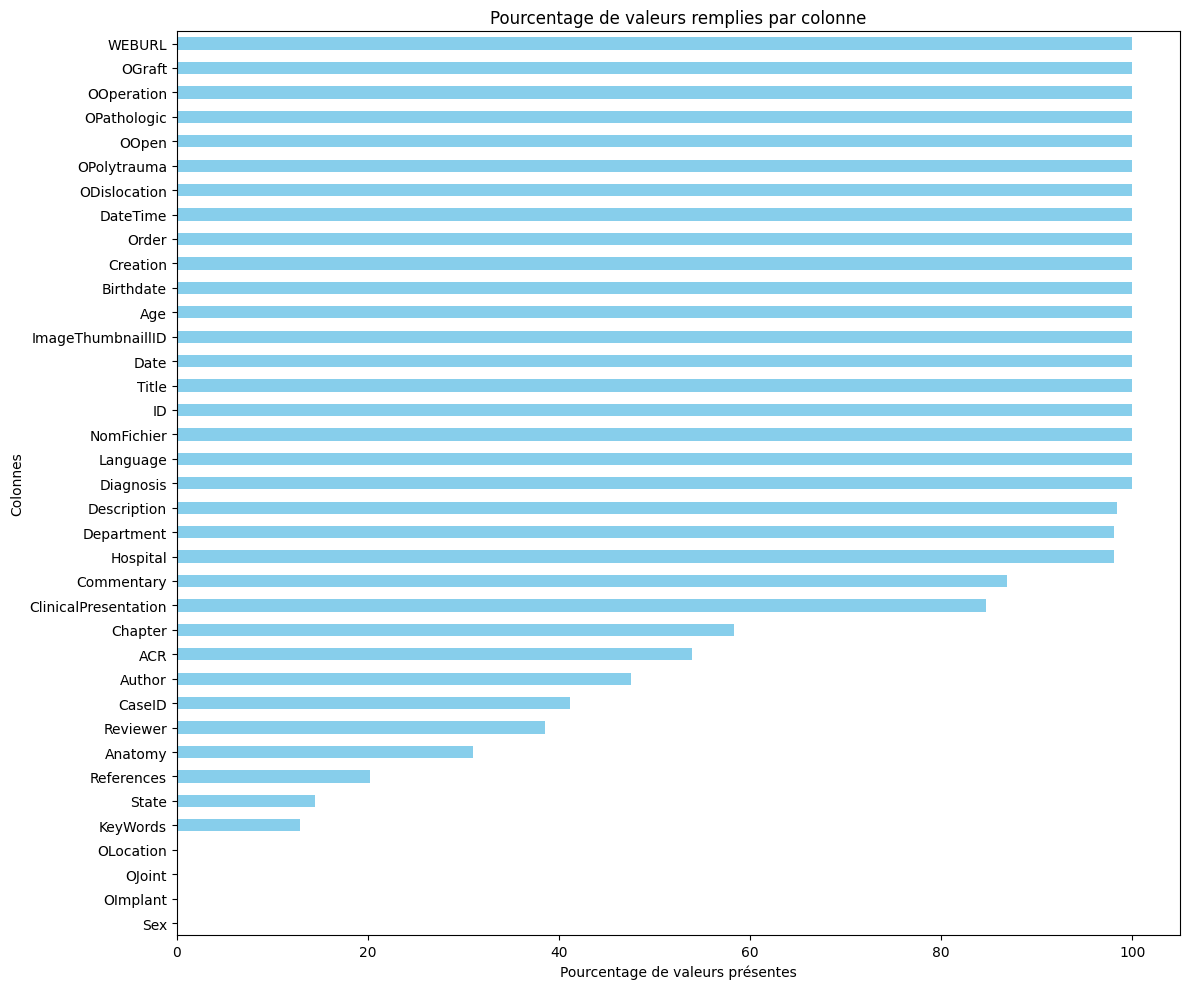

In [ ]:
import matplotlib.pyplot as plt

# Pourcentage de valeurs manquantes
missing_percent = df_main.isna().mean() * 100

# Pourcentage de valeurs présentes
filled_percent = 100 - missing_percent

plt.figure(figsize=(12, 10))  # taille de la figure
filled_percent.sort_values().plot(kind="barh", color="skyblue")  # tri et couleur

plt.xlabel("Pourcentage de valeurs présentes")
plt.ylabel("Colonnes")
plt.title("Pourcentage de valeurs remplies par colonne")
plt.yticks(rotation=0)  # noms des colonnes horizontaux
plt.tight_layout()      # ajuste l'espace pour éviter le chevauchement
plt.show()


Set a threshold to eliminate fields with too many missing values.

In [ ]:
import pandas as pd

# Calculer le pourcentage de valeurs manquantes par colonne
missing_percent = df_main.isna().mean() * 100
print(missing_percent)

# Fixer un seuil (ex : 50%)
threshold = 50

# Sélectionner les colonnes à garder (moins de 50% de NaN)
cols_to_keep = missing_percent[missing_percent <= threshold].index
df_main_cleaned = df_main[cols_to_keep]

print(f"Colonnes conservées ({len(cols_to_keep)}): {list(cols_to_keep)}")


NomFichier                0.000000
ID                        0.000000
Description               1.596688
Diagnosis                 0.059137
Sex                     100.000000
CaseID                   58.840923
ClinicalPresentation     15.316381
Commentary               13.128326
KeyWords                 87.108220
Anatomy                  69.012419
Chapter                  41.632170
ACR                      46.126552
References               79.775281
Author                   52.454169
Reviewer                 61.442933
Hospital                  1.892371
Department                1.892371
State                    85.511532
Date                      0.000000
Language                  0.059137
Title                     0.000000
Birthdate                 0.000000
Age                       0.000000
ImageThumbnaillID         0.000000
Creation                  0.000000
DateTime                  0.000000
Order                     0.000000
OJoint                   99.940863
OLocation           

Dropping the corresponding columns

In [ ]:
df_main.drop(columns=missing_percent[missing_percent > threshold].index, inplace=True)


In [ ]:
df_main.shape #pour vérifier le drop

(1691, 26)

Making sure we don't have any duplicates

In [ ]:
# Vérifier s'il y a des doublons
print(f"Nombre de doublons : {df_main.duplicated().sum()}")

# Supprimer les doublons si nécessaire
df_main.drop_duplicates(inplace=True)


Nombre de doublons : 0


 Ensuring that each column has the appropriate data type for analysis and modeling.

In [ ]:
df_main.dtypes

,0
NomFichier,object
ID,object
Description,object
Diagnosis,object
ClinicalPresentation,object
Commentary,object
Chapter,object
ACR,object
Hospital,object
Department,object


Combine the date and datetime into a single timestamp column.

In [ ]:
df_main[["Date", "DateTime"]]


,Date,DateTime
0,21.03.2003,18:04:12
1,21.03.2003,18:04:09
2,21.03.2003,18:04:13
3,21.03.2003,18:04:16
4,21.03.2003,18:04:13
...,...,...
1686,21.03.2003,18:04:09
1687,21.03.2003,18:04:14
1688,21.03.2003,18:04:13
1689,21.03.2003,18:04:15


In [ ]:
# 1️⃣ Convertir la colonne 'Date' en datetime
df_main['Date'] = pd.to_datetime(df_main['Date'], format='%d.%m.%Y', errors='coerce')
df_main['DateTime_only'] = pd.to_timedelta(df_main['DateTime'])
df_main['Timestamp'] = df_main['Date'] + df_main['DateTime_only']
df_main.drop(columns=['Date', 'DateTime', 'DateTime_only'], inplace=True)

In [ ]:
df_main['Timestamp'].head()

,Timestamp
0,2003-03-21 18:04:12
1,2003-03-21 18:04:09
2,2003-03-21 18:04:13
3,2003-03-21 18:04:16
4,2003-03-21 18:04:13


In [ ]:
df_main['Birthdate'] = pd.to_datetime(df_main['Birthdate'], format='%d.%m.%Y', errors='coerce')

In [ ]:
df_main['Creation'] = pd.to_datetime(df_main['Creation'], format='%d.%m.%Y', errors='coerce')

In [ ]:
df_main['ID'] = pd.to_numeric(df_main['ID'], errors='coerce')

In [ ]:
df_main['Age'] = pd.to_numeric(df_main['Age'], errors='coerce')

In [ ]:
df_main['ImageThumbnaillID'] = pd.to_numeric(df_main['ImageThumbnaillID'], errors='coerce')

In [ ]:
df_main.dtypes

,0
NomFichier,object
ID,int64
Description,object
Diagnosis,object
ClinicalPresentation,object
Commentary,object
Chapter,object
ACR,object
Hospital,object
Department,object


##Fields Understanding & Cleaning

In [ ]:
# Afficher le nombre de valeurs uniques pour chaque colonne
unique_counts = df_main.nunique(dropna=True)  # dropna=True ignore les NaN
print(unique_counts)


NomFichier              1691
ID                      1691
Description             1584
Diagnosis               1447
ClinicalPresentation    1343
Commentary              1346
Chapter                  190
ACR                      641
Hospital                   1
Department                 4
Language                   1
Title                     41
Birthdate                  1
Age                       93
ImageThumbnaillID        958
Creation                 140
Order                    126
ODislocation               1
OPolytrauma                1
OOpen                      1
OPathologic                1
OOperation                 2
OGraft                     1
WEBURL                  1691
Timestamp                392
dtype: int64


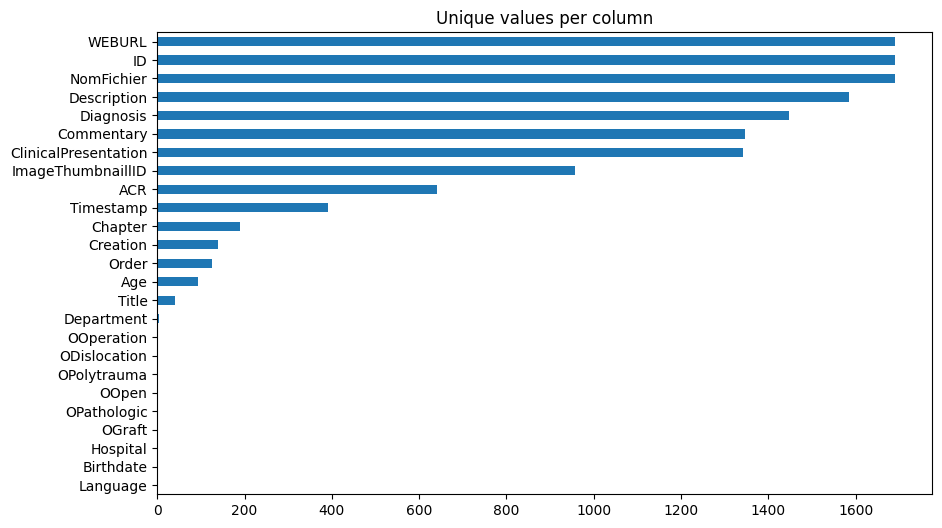

In [ ]:
import matplotlib.pyplot as plt


df_main.nunique().sort_values(ascending=True).plot(kind='barh', figsize=(10,6))
plt.title("Unique values per column")
plt.show()



In [ ]:
unique_counts = df_main.nunique(dropna=True)

# Colonnes à supprimer (1 ou 2 valeurs uniques)
cols_to_drop = unique_counts[unique_counts <= 2].index
df_main.drop(columns=cols_to_drop, inplace=True)

In [ ]:
#pas besoin d'order, on a déja un id
df_main=df_main.drop(columns="Order")

Standardize the values of the department field.


In [ ]:
df_main["Department"].unique()

array(['Radiologie', 'Département de Radiologie', 'Anatomie', <NA>,
       'Hémathologie'], dtype=object)

In [ ]:
#pour standariser les valeurs, on peut rempalcer les valeurs Département de Radiologie par Radiologie
df_main['Department'] = df_main['Department'].replace('Département de Radiologie', 'Radiologie')

Process the age and sex columns

In [ ]:
df_main["Age"].value_counts(dropna=False)

,count
Age,
0,1237
50,19
60,15
40,13
30,12
...,...
94,1
22,1
95,1


We noticed that the ClinicalPresentation column contains the age, so we will fill some of the zero values in the Age column using this field.

In [ ]:
df_main["ClinicalPresentation"].head()

,ClinicalPresentation
0,"Patient de 64 ans, hémodialysé, avec douleurs\..."
1,PR chez un patient de 56\nans.
2,Patient de 35 ans connu pour une PSH droite.\n...
3,Status un an après traumatisme de l'épaule\nga...
4,Douleurs cervicales.


In [ ]:
import re
import pandas as pd

# --- Fonction pour extraire l'âge depuis ClinicalPresentation ---
def extract_age_from_text(text):
    if isinstance(text, str):
        # Recherche des motifs comme :
        # "un patient de 40 ans", "patiente âgée de 69 ans", "un homme de 25 ans", etc.
        match = re.search(r'(\d{1,3})\s*ans', text)
        if match:
            age = int(match.group(1))
            # Filtrage pour éviter les âges aberrants (>120)
            if 0 < age < 120:
                return age
    return None

# --- Remplacer les âges à 0 par ceux extraits ---
def corriger_age(df):
    for i, row in df.iterrows():
        if row["Age"] == 0:
            age_extrait = extract_age_from_text(row["ClinicalPresentation"])
            if age_extrait is not None:
                df.at[i, "Age"] = age_extrait
    return df

# --- Application ---
df_main = corriger_age(df_main)

# --- Vérification ---
print(df_main[df_main["Age"] == 0].shape[0], "valeurs d'âge restantes à 0")


558 valeurs d'âge restantes à 0


Similarly for the sex column, which has a lot of null values but useful for our analysis,so we were able to extract it from the clinical presentation.

In [ ]:
import pandas as pd
import numpy as np

def detect_sexe(text):
    if pd.isna(text):
        return np.nan
    text_lower = str(text).lower()
    if "patiente" in text_lower:
        return "W"
    elif "patient" in text_lower:
        return "M"
    else:
        return np.nan

# Appliquer la fonction
df_main["sexe"] = df_main["ClinicalPresentation"].apply(detect_sexe)


In [ ]:
df_main["sexe"].value_counts()

,count
sexe,
M,541
W,417


# Textual Feature Extraction

For our analytical vision, we need to extract values and relevant information from our textual columns, which are not directly usable as raw text in our OLAP model. That’s why we proceed with extracting this information in order to gain a better understanding of patients and their cases. We will particularly address case severity, diagnostic groups, and affected organs.

*Case Severity*

In [ ]:
import re
from collections import Counter

class MedicalSeverityExtractor:
    """
    Multi-signal approach for extracting severity from French medical text
    """

    def __init__(self):
        # Signal 1: Explicit severity keywords (merged and deduplicated)
        self.severity_keywords = {
            'critical': sorted(list(set([
                'critique', 'fatale', 'issue fatale', 'pronostic reserve', 'pronostic reserve',
                'risque vital', 'vital', 'alarmante', 'urgence', 'urgence vitale',
                'obstruction complete', 'etat de choc', 'complication grave', 'agressif',
                'destruction', 'necrose', 'hemorragie massive', 'decompensation',
                'insuffisance aigue', 'amputation', 'infarctus', 'rupture',
                'collapse', 'arret cardiaque', 'degradation rapide'
            ]))),

            'severe': sorted(list(set([
                'grave', 'severe', 'tres mal', 'pronostic engage', 'important',
                'majeur', 'massif', 'marque', 'evolutif', 'rapide', 'complication',
                'complications', 'douleur intense', 'inflammation marquee',
                'infection severe', 'deshydratation importante', 'degats etendus',
                'atteinte multiple', 'pronostic reserve', 'deterioration'
            ]))),

            'moderate': sorted(list(set([
                'modere', 'moderee', 'moderement', 'moyen', 'partiel', 'anormal',
                'limite', 'localise', 'discret', 'rare', 'faible', 'modest',
                'quelques signes', 'non specifique', 'degre moyen',
                'surveillance', 'attention'
            ]))),

            'mild': sorted(list(set([
                'leger', 'legere', 'legerement', 'benin', 'mineur', 'faible intensite',
                'modere a leger', 'normal', 'sans gravite', 'amelioration', 'stabilise',
                'peu marque', 'absence de complication', 'etat stable', 'aucune conclusion'
            ])))
        }

        # Signal 2: Urgency indicators
        self.urgency_markers = {
            'high': ['immediat', 'urgent', 'urgence', 'rapidement',
                     'hospitalisation', 'soins intensifs', 'reanimation'],
            'medium': ['surveillance', 'controle', 'suivi rapproche'],
            'low': ['programme', 'electif', 'ambulatoire', 'surveillance simple']
        }

        # Signal 3: Complication indicators
        self.complication_markers = [
            'complication', 'surinfection', 'sepsis', 'choc',
            'defaillance', 'rupture', 'hemorragie', 'necrose',
            'abces', 'infection secondaire', 'aggravation'
        ]

        # Signal 4: Extent/spread indicators
        self.extent_markers = {
            'extensive': ['diffus', 'generalise', 'etendu', 'multiple',
                          'bilateral', 'multifocal', 'dissemine'],
            'localized': ['localise', 'focal', 'unique', 'isole', 'limite']
        }

        # Signal 5: High-risk conditions
        self.high_risk_conditions = [
            'metastase', 'maligne', 'cancer', 'carcinome',
            'infarctus', 'embolie', 'thrombose', 'ischemie'
        ]

    def normalize_text(self, text):
        """Normalize French text"""
        if pd.isna(text):
            return ""
        text = str(text).lower()

        # Remove accents for matching
        import unicodedata
        text = ''.join(
            c for c in unicodedata.normalize('NFD', text)
            if unicodedata.category(c) != 'Mn'
        )
        text = re.sub(r'[^\w\s]', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        return text.strip()

    def score_explicit_severity(self, text):
        """Score based on explicit severity keywords"""
        scores = {'critical': 0, 'severe': 0, 'moderate': 0, 'mild': 0}

        for level, keywords in self.severity_keywords.items():
            for kw in keywords:
                if kw in text:
                    scores[level] += 1

        return scores

    def score_urgency(self, text):
        """Score based on treatment urgency"""
        score = 0

        for kw in self.urgency_markers['high']:
            if kw in text:
                score += 2

        for kw in self.urgency_markers['medium']:
            if kw in text:
                score += 1

        for kw in self.urgency_markers['low']:
            if kw in text:
                score -= 0.5

        return max(0, score)

    def score_complications(self, text):
        """Score based on complication indicators"""
        count = sum(1 for marker in self.complication_markers if marker in text)
        return min(count * 0.5, 3)  # Cap at 3=plafon

    def score_extent(self, text):
        """Score based on anatomical extent"""
        extensive_count = sum(
            1 for marker in self.extent_markers['extensive'] if marker in text
        )
        localized_count = sum(
            1 for marker in self.extent_markers['localized'] if marker in text
        )

        return extensive_count - localized_count * 0.5

    def score_high_risk(self, text):
        """Score based on high-risk conditions"""
        count = sum(1 for condition in self.high_risk_conditions if condition in text)
        return min(count, 2)

    #Combining all the scores accordingly
    def extract_severity(self, text):
        """
        Main extraction method combining all signals
        Returns: (severity_level, confidence_score)
        """
        text = self.normalize_text(text)

        if not text:
            return 'unknown', 0.0

        # Get all signal scores
        explicit_scores = self.score_explicit_severity(text)
        urgency = self.score_urgency(text)
        complications = self.score_complications(text)
        extent = self.score_extent(text)
        high_risk = self.score_high_risk(text)

        # If explicit keywords found, prioritize them!!!!!!!!!!!!!!!!!!
        if sum(explicit_scores.values()) > 0:
            max_explicit = max(explicit_scores, key=explicit_scores.get)
            confidence = explicit_scores[max_explicit] / sum(explicit_scores.values())

            # Adjust based on other signals!!!!!!un mécanisme de sécurité contre les faux négatifs
            adjustment = (
                urgency * 0.15 + complications * 0.15 +
                extent * 0.1 + high_risk * 0.1
            )

            # If strong conflicting signals, adjust severity
            if adjustment > 2 and max_explicit in ['mild', 'moderate']:
                if max_explicit == 'mild':
                    max_explicit = 'moderate'
                else:
                    max_explicit = 'severe'

            return max_explicit, min(confidence + adjustment * 0.1, 1.0)

        # If no explicit keywords, use composite score
        composite_score = (
            urgency * 0.35 +
            complications * 0.35 +
            extent * 0.15 +
            high_risk * 0.15
        )

        if composite_score >= 3:
            return 'critical', 0.6
        elif composite_score >= 2:
            return 'severe', 0.5
        elif composite_score >= 1:
            return 'moderate', 0.4
        elif composite_score > 0:
            return 'mild', 0.3
        else:
            return 'unknown', 0.0




In [ ]:
def process_dataframe(df):
    """Process entire dataframe"""
    extractor = MedicalSeverityExtractor()

    # Combine text fields
    df['combined_text'] = (df['Description'].fillna('') + ' ' +
                          df['Commentary'].fillna('') + ' ' +
                          df['ClinicalPresentation'].fillna(''))

    # Extract severity and confidence
    results = df['combined_text'].apply(
        lambda x: extractor.extract_severity(x)
    )

    df['severity_level'] = results.apply(lambda x: x[0])
    df['severity_confidence'] = results.apply(lambda x: x[1])

    return df

In [ ]:
df_main2=df_main.copy()

In [ ]:
df_processed = process_dataframe(df_main2)

print(df_processed['severity_level'].value_counts())
print(f"\nMean confidence: {df_processed['severity_confidence'].mean():.2f}")

df_confident = df_processed[df_processed['severity_confidence'] > 0.5]
print(f"\nHigh-confidence cases: {len(df_confident)}")

severity_level
moderate    466
severe      396
mild        318
unknown     273
critical    238
Name: count, dtype: int64

Mean confidence: 0.56

High-confidence cases: 948


In [ ]:
df_processed.head(5)

,NomFichier,ID,Description,Diagnosis,ClinicalPresentation,Commentary,Chapter,ACR,Department,Title,Age,ImageThumbnaillID,Creation,WEBURL,Timestamp,sexe,combined_text,severity_level,severity_confidence
0,case2827_fr.xml,2827,"Bassins face du l3.7.84, 22.1.88 et du 25.l.89...",Protrusion acétabulaire gauche secondaire à un...,"Patient de 64 ans, hémodialysé, avec douleurs\...",Très bel exemple d'une coxarthrose évoluant\np...,<NA>,"442.786, 442.77",Radiologie,Collection Kindynis - Ostéoarticulaire,64,0,2001-08-07,\nhttp://129.195.254.38:5000/4DMETHOD/_HTML_MC...,2003-03-21 18:04:12,M,"Bassins face du l3.7.84, 22.1.88 et du 25.l.89...",critical,1.0000
1,case2792_fr.xml,2792,Coude droit du 25.01.1967 : Pincement articula...,Polyarthrite rhumatoïde avec atteinte du coude...,PR chez un patient de 56\nans.,<NA>,<NA>,422.711,Radiologie,Collection Kindynis - Ostéoarticulaire,56,0,2001-08-07,\nhttp://129.195.254.38:5000/4DMETHOD/_HTML_MC...,2003-03-21 18:04:09,M,Coude droit du 25.01.1967 : Pincement articula...,mild,0.3000
2,case2834_fr.xml,2834,Epaule droite du 6.04.1993 : Importante calcif...,PSH de l'épaule droite associée à un syndrome ...,Patient de 35 ans connu pour une PSH droite.\n...,Les calcifications ne sont généralement pas vi...,<NA>,"419.253, 419.481",Radiologie,Collection Kindynis - Ostéoarticulaire,35,0,2001-08-07,\nhttp://129.195.254.38:5000/4DMETHOD/_HTML_MC...,2003-03-21 18:04:13,M,Epaule droite du 6.04.1993 : Importante calcif...,critical,0.5075
3,case2873_fr.xml,2873,Epaule gauche du 16.12.1993 : Les rapports\nos...,Status un an post-traumatique de l'épaule gauc...,Status un an après traumatisme de l'épaule\nga...,Ces fractures sont extrêmement difficiles à me...,<NA>,"412.4811, 412.411",Radiologie,Collection Kindynis - Ostéoarticulaire,0,0,2001-08-07,\nhttp://129.195.254.38:5000/4DMETHOD/_HTML_MC...,2003-03-21 18:04:16,NaN,Epaule gauche du 16.12.1993 : Les rapports\nos...,unknown,0.0000
4,case2843_fr.xml,2843,L'ensemble de la colonne cervicale est parfait...,Rétrolisthésis de C4 sur C5,Douleurs cervicales.,Le terme rétrolisthésis signifie qu'il existe ...,<NA>,31.4233,Radiologie,Collection Kindynis - Ostéoarticulaire,0,0,2001-08-07,\nhttp://129.195.254.38:5000/4DMETHOD/_HTML_MC...,2003-03-21 18:04:13,NaN,L'ensemble de la colonne cervicale est parfait...,mild,1.0000


*Diagnostic Group*

In [ ]:
df_processed['Diagnosis'].nunique()


1447

In [ ]:
df_processed['Diagnosis'].value_counts().head(10)


,count
Diagnosis,
Polyarthrite Rhumatoïde,14
Angiome intramusculaire,7
Polyarthrite Rhumatoide,7
Emphysème pulmonaire,6
Schwannome,6
Lipome intramusculaire,6
Goutte,5
Maladie de Bechterew avec sacro-iliite\nbilatérale.,5
Arthrite psoriasique,5


In [ ]:
!python -m spacy download fr_core_news_md


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 MB 16.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy

# 1. copy the dataframe so we don't clobber original
dfProcessed = df_processed.copy()

# 2. light cleaning function that preserves accents for spaCy
def cleanTextBasic(text):
    text = str(text).lower()
    # keep letters including common accented ranges, replace everything else with space
    text = re.sub(r"[^a-zà-ÿ\s]", " ", text)
    # remove common French small words that just add noise (you can expand this)
    text = re.sub(r"\b(de|du|la|le|les|des|en|chez|pour|un|une|et|au|aux)\b", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# 3. apply the basic cleaner into a new column
dfProcessed["DiagnosisClean"] = dfProcessed["Diagnosis"].fillna("").apply(cleanTextBasic)

# 4. load spaCy french model
nlp = spacy.load("fr_core_news_md")   # use md for more accurate lemmas

# 5. dynamic ignore set - start with anatomical and boilerplate tokens
ignoreSet = set([
    "gauche", "droit", "bilateral", "bilaterale", "bilaterale", "epaule", "cheville",
    "main", "membre", "jambe", "pied", "genou", "hanche", "poignet", "lat", "chez",
    "patiente", "patient", "connu", "connue", "type", "aigu", "chronique"
])

# 6. normalization function using POS and lemma
def normalizeDiagnosis(text):
    doc = nlp(text)
    keep = []
    for token in doc:
        # keep nouns and adjectives only
        if token.pos_ in ["NOUN", "ADJ"]:
            lemma = token.lemma_.lower()
            if lemma not in ignoreSet and len(lemma) > 2:
                keep.append(lemma)
    # join lemmas in original order to preserve multiword roots like "tumeur osseuse"
    return " ".join(keep).strip()

# 7. apply normalization into a new column
dfProcessed["DiagnosisNormalized"] = dfProcessed["DiagnosisClean"].apply(normalizeDiagnosis)


In [ ]:
dfProcessed["DiagnosisNormalized"].value_counts().head(50)\
    .reset_index()\
    .rename(columns={"index": "Diagnosis Normalisée", "DiagnosisNormalized": "Occurrences"})\
    .style.background_gradient(cmap="Blues")\
    .set_caption("Top 50 Diagnoses Normalisées")


,Occurrences,count
0,,18
1,polyarthrite rhumatoïde,16
2,polyarthrite rhumatoid,9
3,quiz,8
4,colonne cervical normal,7
5,sarcoïdose stade,7
6,chondrocalcinose,7
7,fracture,7
8,maladie sacro iliite bilatéral,7
9,angiome intramusculaire,7


In [ ]:
from IPython.display import display

sample = dfProcessed[["Diagnosis", "DiagnosisClean", "DiagnosisNormalized"]].sample(20, random_state=42)
print("\nSample transformations:")
display(sample)



Sample transformations:


,Diagnosis,DiagnosisClean,DiagnosisNormalized
989,Pachypleurite calcifiée,pachypleurite calcifiée,pachypleurite calcifié
1636,Protrusion acétabulaire bilatérale. Coxarthros...,protrusion acétabulaire bilatérale coxarthrose...,protrusion acétabulaire bilatéral coxarthrose ...
1216,Fracture de Segond.,fracture segond,fracture segond
1174,Hémophilie avec atteinte articulaire du genou ...,hémophilie avec atteinte articulaire genou gau...,hémophilie atteinte articulaire coud
1668,Iléus biliaire,iléus biliaire,iléus biliaire
78,Métastases d'un mélanome,métastases d mélanome,métastase mélanome
1187,Fracture pathologique sur fibrome non ossifian...,fracture pathologique sur fibrome non ossifian...,fracture pathologique fibrome ossifiant fémur
1617,"Premier cunéiforme bipartite bilatéral, sympto...",premier cunéiforme bipartite bilatéral symptom...,premier cunéiforme bipartite bilatéral symptom...
1570,Tumeur à cellules géantes de la partie proxima...,tumeur à cellules géantes partie proximale tib...,tumeur cellule géant partie proximal tibia
69,Fibrosarcome epithélioïde,fibrosarcome epithélioïde,fibrosarcome


We noticed that the diagnosis is generally found in the first one or two words of the Diagnosis column.”

In [ ]:
dfProcessed["Diagnosis_root"] = dfProcessed["DiagnosisNormalized"].apply(lambda x: " ".join(x.split()[:2]))  # try 1 or 2 tokens
root_counts = dfProcessed["Diagnosis_root"].value_counts()
print(root_counts.head(20))

Diagnosis_root
polyarthrite rhumatoïde     32
fracture stress             28
métastase ostéolytique      27
maladie paget               24
maladie sacro               21
                            18
fibrome ossifiant           14
protrusion acétabulaire     14
kyste osseux                13
colonne cervical            13
métastase osseux            11
hernie discal               10
métastase ostéoblastique    10
fracture pathologique       10
maladie atteinte            10
ostéome cortical             9
myosite ossifiant            9
polyarthrite rhumatoid       9
métastase mixte              8
arthrose articulation        8
Name: count, dtype: int64


In [ ]:
print("Unique before:", dfProcessed["DiagnosisNormalized"].nunique())
print("Unique after:", dfProcessed["Diagnosis_root"].nunique())


Unique before: 1317
Unique after: 934


In [ ]:
dfProcessed.head()

,NomFichier,ID,Description,Diagnosis,ClinicalPresentation,Commentary,Chapter,ACR,Department,Title,...,Creation,WEBURL,Timestamp,sexe,combined_text,severity_level,severity_confidence,DiagnosisClean,DiagnosisNormalized,Diagnosis_root
0,case2827_fr.xml,2827,"Bassins face du l3.7.84, 22.1.88 et du 25.l.89...",Protrusion acétabulaire gauche secondaire à un...,"Patient de 64 ans, hémodialysé, avec douleurs\...",Très bel exemple d'une coxarthrose évoluant\np...,<NA>,"442.786, 442.77",Radiologie,Collection Kindynis - Ostéoarticulaire,...,2001-08-07,\nhttp://129.195.254.38:5000/4DMETHOD/_HTML_MC...,2003-03-21 18:04:12,M,"Bassins face du l3.7.84, 22.1.88 et du 25.l.89...",critical,1.0000,protrusion acétabulaire gauche secondaire à co...,protrusion acétabulaire secondaire coxarthrose,protrusion acétabulaire
1,case2792_fr.xml,2792,Coude droit du 25.01.1967 : Pincement articula...,Polyarthrite rhumatoïde avec atteinte du coude...,PR chez un patient de 56\nans.,<NA>,<NA>,422.711,Radiologie,Collection Kindynis - Ostéoarticulaire,...,2001-08-07,\nhttp://129.195.254.38:5000/4DMETHOD/_HTML_MC...,2003-03-21 18:04:09,M,Coude droit du 25.01.1967 : Pincement articula...,mild,0.3000,polyarthrite rhumatoïde avec atteinte coude droit,polyarthrite rhumatoïde atteinte coude,polyarthrite rhumatoïde
2,case2834_fr.xml,2834,Epaule droite du 6.04.1993 : Importante calcif...,PSH de l'épaule droite associée à un syndrome ...,Patient de 35 ans connu pour une PSH droite.\n...,Les calcifications ne sont généralement pas vi...,<NA>,"419.253, 419.481",Radiologie,Collection Kindynis - Ostéoarticulaire,...,2001-08-07,\nhttp://129.195.254.38:5000/4DMETHOD/_HTML_MC...,2003-03-21 18:04:13,M,Epaule droite du 6.04.1993 : Importante calcif...,critical,0.5075,psh l épaule droite associée à syndrome confli...,psh épaule droite syndrome conflit acromial,psh épaule
3,case2873_fr.xml,2873,Epaule gauche du 16.12.1993 : Les rapports\nos...,Status un an post-traumatique de l'épaule gauc...,Status un an après traumatisme de l'épaule\nga...,Ces fractures sont extrêmement difficiles à me...,<NA>,"412.4811, 412.411",Radiologie,Collection Kindynis - Ostéoarticulaire,...,2001-08-07,\nhttp://129.195.254.38:5000/4DMETHOD/_HTML_MC...,2003-03-21 18:04:16,NaN,Epaule gauche du 16.12.1993 : Les rapports\nos...,unknown,0.0000,status an post traumatique l épaule gauche ave...,status post traumatique épaule ancien fracture,status post
4,case2843_fr.xml,2843,L'ensemble de la colonne cervicale est parfait...,Rétrolisthésis de C4 sur C5,Douleurs cervicales.,Le terme rétrolisthésis signifie qu'il existe ...,<NA>,31.4233,Radiologie,Collection Kindynis - Ostéoarticulaire,...,2001-08-07,\nhttp://129.195.254.38:5000/4DMETHOD/_HTML_MC...,2003-03-21 18:04:13,NaN,L'ensemble de la colonne cervicale est parfait...,mild,1.0000,rétrolisthésis c sur c,rétrolisthésis,rétrolisthésis


In [ ]:
dfProcessed.drop(columns=['DiagnosisClean', 'DiagnosisNormalized'], inplace=True)

In [ ]:
dfProcessed.head()

,NomFichier,ID,Description,Diagnosis,ClinicalPresentation,Commentary,Chapter,ACR,Department,Title,Age,ImageThumbnaillID,Creation,WEBURL,Timestamp,sexe,combined_text,severity_level,severity_confidence,Diagnosis_root
0,case2827_fr.xml,2827,"Bassins face du l3.7.84, 22.1.88 et du 25.l.89...",Protrusion acétabulaire gauche secondaire à un...,"Patient de 64 ans, hémodialysé, avec douleurs\...",Très bel exemple d'une coxarthrose évoluant\np...,<NA>,"442.786, 442.77",Radiologie,Collection Kindynis - Ostéoarticulaire,64,0,2001-08-07,\nhttp://129.195.254.38:5000/4DMETHOD/_HTML_MC...,2003-03-21 18:04:12,M,"Bassins face du l3.7.84, 22.1.88 et du 25.l.89...",critical,1.0000,protrusion acétabulaire
1,case2792_fr.xml,2792,Coude droit du 25.01.1967 : Pincement articula...,Polyarthrite rhumatoïde avec atteinte du coude...,PR chez un patient de 56\nans.,<NA>,<NA>,422.711,Radiologie,Collection Kindynis - Ostéoarticulaire,56,0,2001-08-07,\nhttp://129.195.254.38:5000/4DMETHOD/_HTML_MC...,2003-03-21 18:04:09,M,Coude droit du 25.01.1967 : Pincement articula...,mild,0.3000,polyarthrite rhumatoïde
2,case2834_fr.xml,2834,Epaule droite du 6.04.1993 : Importante calcif...,PSH de l'épaule droite associée à un syndrome ...,Patient de 35 ans connu pour une PSH droite.\n...,Les calcifications ne sont généralement pas vi...,<NA>,"419.253, 419.481",Radiologie,Collection Kindynis - Ostéoarticulaire,35,0,2001-08-07,\nhttp://129.195.254.38:5000/4DMETHOD/_HTML_MC...,2003-03-21 18:04:13,M,Epaule droite du 6.04.1993 : Importante calcif...,critical,0.5075,psh épaule
3,case2873_fr.xml,2873,Epaule gauche du 16.12.1993 : Les rapports\nos...,Status un an post-traumatique de l'épaule gauc...,Status un an après traumatisme de l'épaule\nga...,Ces fractures sont extrêmement difficiles à me...,<NA>,"412.4811, 412.411",Radiologie,Collection Kindynis - Ostéoarticulaire,0,0,2001-08-07,\nhttp://129.195.254.38:5000/4DMETHOD/_HTML_MC...,2003-03-21 18:04:16,NaN,Epaule gauche du 16.12.1993 : Les rapports\nos...,unknown,0.0000,status post
4,case2843_fr.xml,2843,L'ensemble de la colonne cervicale est parfait...,Rétrolisthésis de C4 sur C5,Douleurs cervicales.,Le terme rétrolisthésis signifie qu'il existe ...,<NA>,31.4233,Radiologie,Collection Kindynis - Ostéoarticulaire,0,0,2001-08-07,\nhttp://129.195.254.38:5000/4DMETHOD/_HTML_MC...,2003-03-21 18:04:13,NaN,L'ensemble de la colonne cervicale est parfait...,mild,1.0000,rétrolisthésis


In [ ]:
df_main=dfProcessed.copy()

*Organ affected*

In [ ]:

!pip install gliner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.3/76.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.22.1
    Uninstalling tokenizers-0.22.1:
      Successfully uninstalled tokenizers-0.22.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.1
    Uninstalling transformers-4.57.1:
      Successfully uninstalled transformers-4.57.1


In [ ]:

import pandas as pd
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from gliner import GLiNER

# Fusionner les champs texte
cols_text = ['Diagnosis', 'Chapter', 'ClinicalPresentation', 'Description']
df_main[cols_text] = df_main[cols_text].fillna('').astype(str)
df_main['texte_complet'] = df_main[cols_text].agg(' '.join, axis=1)

# Charger le modèle GLiNER
model = GLiNER.from_pretrained("almanach/camembert-bio-gliner-v0.1")

def extraire_organe_unique(text, labels=None):
    if labels is None:
        labels = ["AnatomicalStructure", "Organ", "Structure", "Tissue"]
    # Extraction des entités
    entities = model.predict_entities(text, labels=labels, threshold=0.3, flat_ner=True)
    organes_detectes = [e["text"] for e in entities if any(lbl.lower() in e["label"].lower() for lbl in labels)]

    if organes_detectes:
        # Retourner seulement le premier organe détecté
        return organes_detectes[0]
    else:
        # Fallback simple si rien n'est détecté
        # Tu peux ajouter une liste de mots-clés si tu veux
        return "Inconnu"

# Appliquer la fonction sur le DataFrame
df_main['Organe_affecte'] = df_main['texte_complet'].apply(extraire_organe_unique)

# Afficher les 10 premières lignes
print(df_main[['texte_complet', 'Organe_affecte']].head(10))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

gliner_config.json:   0%|          | 0.00/317 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/542M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/374 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/710 [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
/usr/local/lib/python3.12/dist-packages/gliner/data_processing/processor.py:351: UserWarning: Sentence of length 417 has been truncated to 384
  warnings.warn(f"Sentence of length {len(tokens)} has been truncated to {max_len}")
/usr/local/lib/python3.12/dist-packages/gliner/data_processing/processor.py:351: UserWarning: Sentence of length 1124 has been truncated to 384
  warnings.warn(f"Sentence of length {len(tokens)} has been truncated to {max_len}")
/usr/local/lib/python3.12/dist-packages/gliner/data_processing/processor.py:351: UserWarning: Sentence of length 1065 has been truncated to 384
  warnings.warn(f"Sentence of length {len(tokens)} has been truncated to {max_len}")
/usr/local/lib/python3.12/dist-packages/gliner/data_processi

                                       texte_complet  \
0  Protrusion acétabulaire gauche secondaire à un...   
1  Polyarthrite rhumatoïde avec atteinte du coude...   
2  PSH de l'épaule droite associée à un syndrome ...   
3  Status un an post-traumatique de l'épaule gauc...   
4  Rétrolisthésis de C4 sur C5  Douleurs cervical...   
5  PR avec coxite inflammatoire gauche associées ...   
6  Séquelles d'une ancienne fracture de l'apophys...   
7  Récidive d'un kyste osseux solitaire de l'humé...   
8  Psoriasis cutané, avec atteinte osseuse de typ...   
9  Sacro-iliite bilatérale, dans le cadre d'une m...   

                      Organe_affecte  
0                      hanche gauche  
1                       coude\ndroit  
2                      épaule droite  
3                      épaule gauche  
4                                 C4  
5                contenu articulaire  
6  apophyse\ntransverse gauche de L4  
7                     humérus\ndroit  
8       articulations sacro-ilia

In [ ]:
df_main['Organe_affecte'].nunique()

879

In [ ]:
df_main['Organe_affecte'].value_counts(dropna=False)

,count
Organe_affecte,
tissus mous,44
Inconnu,43
thorax,25
sein,20
Thorax,20
...,...
G,1
métatarse,1
articulations coxo-fémorales,1


In [ ]:
df_main.dtypes

,0
NomFichier,object
ID,int64
Description,object
Diagnosis,object
ClinicalPresentation,object
Commentary,object
Chapter,object
ACR,object
Department,object
Title,object


In [ ]:
df_main.drop(columns=["WEBURL"])

,NomFichier,ID,Description,Diagnosis,ClinicalPresentation,Commentary,Chapter,ACR,Department,Title,...,ImageThumbnaillID,Creation,Timestamp,sexe,combined_text,severity_level,severity_confidence,Diagnosis_root,texte_complet,Organe_affecte
0,case2827_fr.xml,2827,"Bassins face du l3.7.84, 22.1.88 et du 25.l.89...",Protrusion acétabulaire gauche secondaire à un...,"Patient de 64 ans, hémodialysé, avec douleurs\...",Très bel exemple d'une coxarthrose évoluant\np...,,"442.786, 442.77",Radiologie,Collection Kindynis - Ostéoarticulaire,...,0,2001-08-07,2003-03-21 18:04:12,M,"Bassins face du l3.7.84, 22.1.88 et du 25.l.89...",critical,1.0000,protrusion acétabulaire,Protrusion acétabulaire gauche secondaire à un...,hanche gauche
1,case2792_fr.xml,2792,Coude droit du 25.01.1967 : Pincement articula...,Polyarthrite rhumatoïde avec atteinte du coude...,PR chez un patient de 56\nans.,<NA>,,422.711,Radiologie,Collection Kindynis - Ostéoarticulaire,...,0,2001-08-07,2003-03-21 18:04:09,M,Coude droit du 25.01.1967 : Pincement articula...,mild,0.3000,polyarthrite rhumatoïde,Polyarthrite rhumatoïde avec atteinte du coude...,coude\ndroit
2,case2834_fr.xml,2834,Epaule droite du 6.04.1993 : Importante calcif...,PSH de l'épaule droite associée à un syndrome ...,Patient de 35 ans connu pour une PSH droite.\n...,Les calcifications ne sont généralement pas vi...,,"419.253, 419.481",Radiologie,Collection Kindynis - Ostéoarticulaire,...,0,2001-08-07,2003-03-21 18:04:13,M,Epaule droite du 6.04.1993 : Importante calcif...,critical,0.5075,psh épaule,PSH de l'épaule droite associée à un syndrome ...,épaule droite
3,case2873_fr.xml,2873,Epaule gauche du 16.12.1993 : Les rapports\nos...,Status un an post-traumatique de l'épaule gauc...,Status un an après traumatisme de l'épaule\nga...,Ces fractures sont extrêmement difficiles à me...,,"412.4811, 412.411",Radiologie,Collection Kindynis - Ostéoarticulaire,...,0,2001-08-07,2003-03-21 18:04:16,NaN,Epaule gauche du 16.12.1993 : Les rapports\nos...,unknown,0.0000,status post,Status un an post-traumatique de l'épaule gauc...,épaule gauche
4,case2843_fr.xml,2843,L'ensemble de la colonne cervicale est parfait...,Rétrolisthésis de C4 sur C5,Douleurs cervicales.,Le terme rétrolisthésis signifie qu'il existe ...,,31.4233,Radiologie,Collection Kindynis - Ostéoarticulaire,...,0,2001-08-07,2003-03-21 18:04:13,NaN,L'ensemble de la colonne cervicale est parfait...,mild,1.0000,rétrolisthésis,Rétrolisthésis de C4 sur C5 Douleurs cervical...,C4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1686,case2802_fr.xml,2802,Thorax du 03.10.1978 : Diagnostic et pourquoi\n?,PR avec atteinte des épaules et de l'articulat...,Patiente de 77 ans.,Ostéopénie diffuse avec érosion gléno-humérale...,,"414.711, 413.711",Radiologie,Collection Kindynis - Ostéoarticulaire,...,0,2001-08-07,2003-03-21 18:04:09,W,Thorax du 03.10.1978 : Diagnostic et pourquoi\...,mild,0.3000,atteinte épaule,PR avec atteinte des épaules et de l'articulat...,épaules
1687,case2849_fr.xml,2849,CT scan du 26.05.1994 : Coupes coronales joint...,Sacro-iliite bilatérale chez un patient porteu...,Patient de 33 ans souffrant de lombalgies\nbas...,Très belle démonstration par CT d'une sacro-il...,,337.74,Radiologie,Collection Kindynis - Ostéoarticulaire,...,0,2001-08-07,2003-03-21 18:04:14,M,CT scan du 26.05.1994 : Coupes coronales joint...,mild,1.0000,sacro iliite,Sacro-iliite bilatérale chez un patient porteu...,érosions osseuses
1688,case2835_fr.xml,2835,Rotations interne et externe de l'épaule droit...,PSH droite. Démonstration de l'intérêt des cli...,Douleurs de l'épaule\ndroite.,La calcification de la coiffe des rotateurs es...,,419.813,Radiologie,Collection Kindynis - Ostéoarticulaire,...,0,2001-08-07,2003-03-21 18:04:13,NaN,Rotations interne et externe de l'épaule droit...,unknown,0.0000,psh droite,PSH droite. Démonstration de l'intérêt des cli...,PSH droite
1689,case2862_fr.xml,2862,Mains du 5.09.1978 : Acro-ostéolyse particuliè...,Scl

In [ ]:
df_main.drop(columns=["texte_complet","combined_text"])

,NomFichier,ID,Description,Diagnosis,ClinicalPresentation,Commentary,Chapter,ACR,Department,Title,Age,ImageThumbnaillID,Creation,WEBURL,Timestamp,sexe,severity_level,severity_confidence,Diagnosis_root,Organe_affecte
0,case2827_fr.xml,2827,"Bassins face du l3.7.84, 22.1.88 et du 25.l.89...",Protrusion acétabulaire gauche secondaire à un...,"Patient de 64 ans, hémodialysé, avec douleurs\...",Très bel exemple d'une coxarthrose évoluant\np...,,"442.786, 442.77",Radiologie,Collection Kindynis - Ostéoarticulaire,64,0,2001-08-07,\nhttp://129.195.254.38:5000/4DMETHOD/_HTML_MC...,2003-03-21 18:04:12,M,critical,1.0000,protrusion acétabulaire,hanche gauche
1,case2792_fr.xml,2792,Coude droit du 25.01.1967 : Pincement articula...,Polyarthrite rhumatoïde avec atteinte du coude...,PR chez un patient de 56\nans.,<NA>,,422.711,Radiologie,Collection Kindynis - Ostéoarticulaire,56,0,2001-08-07,\nhttp://129.195.254.38:5000/4DMETHOD/_HTML_MC...,2003-03-21 18:04:09,M,mild,0.3000,polyarthrite rhumatoïde,coude\ndroit
2,case2834_fr.xml,2834,Epaule droite du 6.04.1993 : Importante calcif...,PSH de l'épaule droite associée à un syndrome ...,Patient de 35 ans connu pour une PSH droite.\n...,Les calcifications ne sont généralement pas vi...,,"419.253, 419.481",Radiologie,Collection Kindynis - Ostéoarticulaire,35,0,2001-08-07,\nhttp://129.195.254.38:5000/4DMETHOD/_HTML_MC...,2003-03-21 18:04:13,M,critical,0.5075,psh épaule,épaule droite
3,case2873_fr.xml,2873,Epaule gauche du 16.12.1993 : Les rapports\nos...,Status un an post-traumatique de l'épaule gauc...,Status un an après traumatisme de l'épaule\nga...,Ces fractures sont extrêmement difficiles à me...,,"412.4811, 412.411",Radiologie,Collection Kindynis - Ostéoarticulaire,0,0,2001-08-07,\nhttp://129.195.254.38:5000/4DMETHOD/_HTML_MC...,2003-03-21 18:04:16,NaN,unknown,0.0000,status post,épaule gauche
4,case2843_fr.xml,2843,L'ensemble de la colonne cervicale est parfait...,Rétrolisthésis de C4 sur C5,Douleurs cervicales.,Le terme rétrolisthésis signifie qu'il existe ...,,31.4233,Radiologie,Collection Kindynis - Ostéoarticulaire,0,0,2001-08-07,\nhttp://129.195.254.38:5000/4DMETHOD/_HTML_MC...,2003-03-21 18:04:13,NaN,mild,1.0000,rétrolisthésis,C4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1686,case2802_fr.xml,2802,Thorax du 03.10.1978 : Diagnostic et pourquoi\n?,PR avec atteinte des épaules et de l'articulat...,Patiente de 77 ans.,Ostéopénie diffuse avec érosion gléno-humérale...,,"414.711, 413.711",Radiologie,Collection Kindynis - Ostéoarticulaire,77,0,2001-08-07,\nhttp://129.195.254.38:5000/4DMETHOD/_HTML_MC...,2003-03-21 18:04:09,W,mild,0.3000,atteinte épaule,épaules
1687,case2849_fr.xml,2849,CT scan du 26.05.1994 : Coupes coronales joint...,Sacro-iliite bilatérale chez un patient porteu...,Patient de 33 ans souffrant de lombalgies\nbas...,Très belle démonstration par CT d'une sacro-il...,,337.74,Radiologie,Collection Kindynis - Ostéoarticulaire,33,0,2001-08-07,\nhttp://129.195.254.38:5000/4DMETHOD/_HTML_MC...,2003-03-21 18:04:14,M,mild,1.0000,sacro iliite,érosions osseuses
1688,case2835_fr.xml,2835,Rotations interne et externe de l'épaule droit...,PSH droite. Démonstration de l'intérêt des cli...,Douleurs de l'épaule\ndroite.,La calcification de la coiffe des rotateurs es...,,419.813,Radiologie,Collection Kindynis - Ostéoarticulaire,0,0,2001-08-07,\nhttp://129.195.254.38:5000/4DMETHOD/_HTML_MC...,2003-03-21 18:04:13,NaN,unknown,0.0000,psh droite,PSH droite
1689,case2862_fr.xml,2862,Mains du 5.09.1978 : Acro-ostéolyse particuliè...,Sclérodermie avec acro-ostéolyse.,Patiente de 55 ans chez qui le diagnostic de\n...,La résorption osseuse de l'extrémité distale d...,,436.6131,Radiologie,Collection Kindynis - Ostéoarticulaire,55,0,2001-08-07,\nhttp://129.195.254.38:5000/4DMETHOD/_HTML_MC...,2003-03-21 18:04:15,W,moderate,1.0000,sclérodermi acro,oesophage


In [ ]:
df_main = df_main.drop(columns=["texte_complet", "combined_text"])


In [ ]:
colonnes_texte = ['Description', 'ClinicalPresentation', 'Commentary', 'Title', 'Diagnosis', 'Chapter', 'Department','sexe']



for col in colonnes_texte:
    if col in df_main.columns:
        df_main[col] = df_main[col].astype(str).str.replace(r'[\r\n]+', ' ', regex=True)

df_main.to_csv("out1.csv", index=False, sep=';', encoding='utf-8-sig')



In [ ]:
df_main.head()

,NomFichier,ID,Description,Diagnosis,ClinicalPresentation,Commentary,Chapter,ACR,Department,Title,Age,ImageThumbnaillID,Creation,WEBURL,Timestamp,sexe,severity_level,severity_confidence,Diagnosis_root,Organe_affecte
0,case2827_fr.xml,2827,"Bassins face du l3.7.84, 22.1.88 et du 25.l.89...",Protrusion acétabulaire gauche secondaire à un...,"Patient de 64 ans, hémodialysé, avec douleurs ...",Très bel exemple d'une coxarthrose évoluant pr...,,"442.786, 442.77",Radiologie,Collection Kindynis - Ostéoarticulaire,64,0,2001-08-07,\nhttp://129.195.254.38:5000/4DMETHOD/_HTML_MC...,2003-03-21 18:04:12,M,critical,1.0000,protrusion acétabulaire,hanche gauche
1,case2792_fr.xml,2792,Coude droit du 25.01.1967 : Pincement articula...,Polyarthrite rhumatoïde avec atteinte du coude...,PR chez un patient de 56 ans.,<NA>,,422.711,Radiologie,Collection Kindynis - Ostéoarticulaire,56,0,2001-08-07,\nhttp://129.195.254.38:5000/4DMETHOD/_HTML_MC...,2003-03-21 18:04:09,M,mild,0.3000,polyarthrite rhumatoïde,coude\ndroit
2,case2834_fr.xml,2834,Epaule droite du 6.04.1993 : Importante calcif...,PSH de l'épaule droite associée à un syndrome ...,Patient de 35 ans connu pour une PSH droite. I...,Les calcifications ne sont généralement pas vi...,,"419.253, 419.481",Radiologie,Collection Kindynis - Ostéoarticulaire,35,0,2001-08-07,\nhttp://129.195.254.38:5000/4DMETHOD/_HTML_MC...,2003-03-21 18:04:13,M,critical,0.5075,psh épaule,épaule droite
3,case2873_fr.xml,2873,Epaule gauche du 16.12.1993 : Les rapports ost...,Status un an post-traumatique de l'épaule gauc...,Status un an après traumatisme de l'épaule gau...,Ces fractures sont extrêmement difficiles à me...,,"412.4811, 412.411",Radiologie,Collection Kindynis - Ostéoarticulaire,0,0,2001-08-07,\nhttp://129.195.254.38:5000/4DMETHOD/_HTML_MC...,2003-03-21 18:04:16,nan,unknown,0.0000,status post,épaule gauche
4,case2843_fr.xml,2843,L'ensemble de la colonne cervicale est parfait...,Rétrolisthésis de C4 sur C5,Douleurs cervicales.,Le terme rétrolisthésis signifie qu'il existe ...,,31.4233,Radiologie,Collection Kindynis - Ostéoarticulaire,0,0,2001-08-07,\nhttp://129.195.254.38:5000/4DMETHOD/_HTML_MC...,2003-03-21 18:04:13,nan,mild,1.0000,rétrolisthésis,C4


In [ ]:
df_main.dtypes


,0
NomFichier,object
ID,int64
Description,object
Diagnosis,object
ClinicalPresentation,object
Commentary,object
Chapter,object
ACR,object
Department,object
Title,object


In [ ]:
import pandas as pd
# 🔹 Nettoyer les colonnes
for col in df_main.columns:
    df_main[col] = df_main[col].astype(str).str.strip()  # enlever espaces début/fin
    df_main[col] = df_main[col].replace({'nan': None})  # remplacer 'nan' en None

# 🔹 Vérifier et nettoyer ID pour ne garder que des entiers
df_main['ID'] = df_main['ID'].str.extract(r'(\d+)')[0]  # extrait uniquement les chiffres
df_main['ID'] = df_main['ID'].astype(int)

# 🔹 Nettoyer les colonnes datetime si nécessaire
for dt_col in ['Creation', 'Timestamp', 'Birthdate']:
    if dt_col in df_main.columns:
        df_main[dt_col] = pd.to_datetime(df_main[dt_col], errors='coerce')  # les erreurs deviennent NaT


In [ ]:
df_main.to_csv("dwarehouse.csv", index=False, sep=';', encoding='utf-8')


In [ ]:
df_main['ID'].apply(type).value_counts()


,count
ID,
<class 'int'>,1691


In [ ]:

df_main[df_main['ID'].apply(lambda x: isinstance(x, str))]


,NomFichier,ID,Description,Diagnosis,ClinicalPresentation,Commentary,Chapter,ACR,Department,Title,Age,ImageThumbnaillID,Creation,WEBURL,Timestamp,sexe,severity_level,severity_confidence,Diagnosis_root,Organe_affecte


In [ ]:
df_main.head(50)

,NomFichier,ID,Description,Diagnosis,ClinicalPresentation,Commentary,Chapter,ACR,Department,Title,Age,ImageThumbnaillID,Creation,WEBURL,Timestamp,sexe,severity_level,severity_confidence,Diagnosis_root,Organe_affecte
0,case2827_fr.xml,2827,"Bassins face du l3.7.84, 22.1.88 et du 25.l.89...",Protrusion acétabulaire gauche secondaire à un...,"Patient de 64 ans, hémodialysé, avec douleurs ...",Très bel exemple d'une coxarthrose évoluant pr...,,"442.786, 442.77",Radiologie,Collection Kindynis - Ostéoarticulaire,64,0,2001-08-07,http://129.195.254.38:5000/4DMETHOD/_HTML_MCas...,2003-03-21 18:04:12,M,critical,1.0,protrusion acétabulaire,hanche gauche
1,case2792_fr.xml,2792,Coude droit du 25.01.1967 : Pincement articula...,Polyarthrite rhumatoïde avec atteinte du coude...,PR chez un patient de 56 ans.,<NA>,,422.711,Radiologie,Collection Kindynis - Ostéoarticulaire,56,0,2001-08-07,http://129.195.254.38:5000/4DMETHOD/_HTML_MCas...,2003-03-21 18:04:09,M,mild,0.3,polyarthrite rhumatoïde,coude\ndroit
2,case2834_fr.xml,2834,Epaule droite du 6.04.1993 : Importante calcif...,PSH de l'épaule droite associée à un syndrome ...,Patient de 35 ans connu pour une PSH droite. I...,Les calcifications ne sont généralement pas vi...,,"419.253, 419.481",Radiologie,Collection Kindynis - Ostéoarticulaire,35,0,2001-08-07,http://129.195.254.38:5000/4DMETHOD/_HTML_MCas...,2003-03-21 18:04:13,M,critical,0.5075,psh épaule,épaule droite
3,case2873_fr.xml,2873,Epaule gauche du 16.12.1993 : Les rapports ost...,Status un an post-traumatique de l'épaule gauc...,Status un an après traumatisme de l'épaule gau...,Ces fractures sont extrêmement difficiles à me...,,"412.4811, 412.411",Radiologie,Collection Kindynis - Ostéoarticulaire,0,0,2001-08-07,http://129.195.254.38:5000/4DMETHOD/_HTML_MCas...,2003-03-21 18:04:16,None,unknown,0.0,status post,épaule gauche
4,case2843_fr.xml,2843,L'ensemble de la colonne cervicale est parfait...,Rétrolisthésis de C4 sur C5,Douleurs cervicales.,Le terme rétrolisthésis signifie qu'il existe ...,,31.4233,Radiologie,Collection Kindynis - Ostéoarticulaire,0,0,2001-08-07,http://129.195.254.38:5000/4DMETHOD/_HTML_MCas...,2003-03-21 18:04:13,None,mild,1.0,rétrolisthésis,C4
5,case2806_fr.xml,2806,Arthrographie de la hanche gauche du 22.12.198...,PR avec coxite inflammatoire gauche associées ...,PR séropositive avec coxite gauche.,Belle démonstration de l'atteinte inflammatoir...,,442.711,Radiologie,Collection Kindynis - Ostéoarticulaire,0,0,2001-08-07,http://129.195.254.38:5000/4DMETHOD/_HTML_MCas...,2003-03-21 18:04:10,None,mild,1.0,coxite inflammatoire,contenu articulaire
6,case2865_fr.xml,2865,Présence d'une déformation de l'apophyse trans...,Séquelles d'une ancienne fracture de l'apophys...,Patient de 4O ans. Cliché de centrage en vue d...,L'anamnèse démontre un ancien traumatisme (chu...,,333.419,Radiologie,Collection Kindynis - Ostéoarticulaire,0,0,2001-08-07,http://129.195.254.38:5000/4DMETHOD/_HTML_MCas...,2003-03-21 18:04:15,M,unknown,0.0,séquelle ancien,apophyse\ntransverse gauche de L4
7,case2842_fr.xml,2842,Bras droit du 16.7.79 : La fracture est actuel...,Récidive d'un kyste osseux solitaire de l'humé...,Garçon de 7 ans. Status 3 ans après fracture s...,Le kyste osseux solitaire se rencontre chez l'...,,"415.3181, 415.456",Radiologie,Collection Kindynis - Ostéoarticulaire,7,10934,2001-08-07,http://129.195.254.38:5000/4DMETHOD/_HTML_MCas...,2003-03-21 18:04:13,None,moderate,1.0,récidive kyste,humérus\ndroit
8,case2836_fr.xml,2836,Bassin du 16.2.82 : Ostéopénie diffuse. Fusion...,"Psoriasis cutané, avec atteinte osseuse de typ...","Patient de 64 ans, avec psoriasis cutané.",Des 5 formes distinctes de l'atteinte osseuse ...,,"337.729, 328.729, 33",Radiologie,Collection Kindynis - Ostéoarticulaire,64,0,2001-08-07,http://129.195.254.38:5000/4DMETHOD/_HTML_MCas...,2003-03-21 18:04:13,M,severe,0.52,psoriasis cutané,articulations sacro-iliaques
9,case2851_fr.xml,2851,Bassin face et coupes tomographiques du 2 et d...,"Sacro-iliite bilatérale